In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        #{'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['t1'],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_t1_0_0_basal_seg_data_norm_e_e_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 1)
(1755717, 3)
validation
(308504, 1)
(308504, 3)
test
(223783, 1)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1)]               0         


 dense (Dense)               (None, 1024)              2048      


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 691459 (2.64 MB)


Trainable params: 691459 (2.64 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 4:17 - loss: 1.2951 - STD: 0.1529 - MAE: 0.4647

  8/176 [>.............................] - ETA: 1s - loss: 1.1410 - STD: 0.1379 - MAE: 0.4304  

 15/176 [=>............................] - ETA: 1s - loss: 1.1153 - STD: 0.0930 - MAE: 0.4346

 22/176 [==>...........................] - ETA: 1s - loss: 1.1027 - STD: 0.0914 - MAE: 0.4334

 28/176 [===>..........................] - ETA: 1s - loss: 1.0958 - STD: 0.0899 - MAE: 0.4329

 34/176 [====>.........................] - ETA: 1s - loss: 1.0905 - STD: 0.0838 - MAE: 0.4330

 41/176 [=====>........................] - ETA: 1s - loss: 1.0844 - STD: 0.0840 - MAE: 0.4320

 47/176 [=======>......................] - ETA: 1s - loss: 1.0789 - STD: 0.0848 - MAE: 0.4308

 51/176 [=======>......................] - ETA: 3s - loss: 1.0755 - STD: 0.0859 - MAE: 0.4299

 57/176 [========>.....................] - ETA: 2s - loss: 1.0702 - STD: 0.0899 - MAE: 0.4280

 64/176 [=========>....................] - ETA: 2s - loss: 1.0648 - STD: 0.0939 - MAE: 0.4261

 71/176 [===========>..................] - ETA: 2s - loss: 1.0603 - STD: 0.0971 - MAE: 0.4246

 78/176 [============>.................] - ETA: 1s - loss: 1.0566 - STD: 0.1002 - MAE: 0.4232

 85/176 [=============>................] - ETA: 1s - loss: 1.0534 - STD: 0.1030 - MAE: 0.4220

 92/176 [==============>...............] - ETA: 1s - loss: 1.0506 - STD: 0.1053 - MAE: 0.4209

 99/176 [===============>..............] - ETA: 1s - loss: 1.0482 - STD: 0.1073 - MAE: 0.4200

105/176 [================>.............] - ETA: 1s - loss: 1.0463 - STD: 0.1089 - MAE: 0.4193

112/176 [==================>...........] - ETA: 1s - loss: 1.0445 - STD: 0.1105 - MAE: 0.4186

119/176 [===================>..........] - ETA: 0s - loss: 1.0429 - STD: 0.1117 - MAE: 0.4180

126/176 [====================>.........] - ETA: 0s - loss: 1.0411 - STD: 0.1132 - MAE: 0.4174

133/176 [=====================>........] - ETA: 0s - loss: 1.0396 - STD: 0.1145 - MAE: 0.4168

140/176 [======================>.......] - ETA: 0s - loss: 1.0384 - STD: 0.1155 - MAE: 0.4163

147/176 [========================>.....] - ETA: 0s - loss: 1.0373 - STD: 0.1164 - MAE: 0.4159

153/176 [=========================>....] - ETA: 0s - loss: 1.0364 - STD: 0.1172 - MAE: 0.4156

160/176 [==========================>...] - ETA: 0s - loss: 1.0355 - STD: 0.1180 - MAE: 0.4152

167/176 [===========================>..] - ETA: 0s - loss: 1.0347 - STD: 0.1187 - MAE: 0.4149

174/176 [============================>.] - ETA: 0s - loss: 1.0339 - STD: 0.1195 - MAE: 0.4146

176/176 [==============================] - 5s 17ms/step - loss: 1.0337 - STD: 0.1196 - MAE: 0.4145 - val_loss: 1.0323 - val_STD: 0.1442 - val_MAE: 0.4091


Epoch 2/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0087 - STD: 0.1312 - MAE: 0.4073

  8/176 [>.............................] - ETA: 1s - loss: 1.0144 - STD: 0.1368 - MAE: 0.4069

 15/176 [=>............................] - ETA: 1s - loss: 1.0152 - STD: 0.1361 - MAE: 0.4073

 21/176 [==>...........................] - ETA: 1s - loss: 1.0148 - STD: 0.1356 - MAE: 0.4074

 28/176 [===>..........................] - ETA: 1s - loss: 1.0151 - STD: 0.1362 - MAE: 0.4073

 35/176 [====>.........................] - ETA: 1s - loss: 1.0144 - STD: 0.1361 - MAE: 0.4072

 42/176 [======>.......................] - ETA: 1s - loss: 1.0148 - STD: 0.1365 - MAE: 0.4071

 49/176 [=======>......................] - ETA: 1s - loss: 1.0150 - STD: 0.1364 - MAE: 0.4072

 56/176 [========>.....................] - ETA: 0s - loss: 1.0152 - STD: 0.1361 - MAE: 0.4073

 63/176 [=========>....................] - ETA: 0s - loss: 1.0151 - STD: 0.1364 - MAE: 0.4072

 70/176 [==========>...................] - ETA: 0s - loss: 1.0149 - STD: 0.1365 - MAE: 0.4071

 76/176 [===========>..................] - ETA: 0s - loss: 1.0150 - STD: 0.1365 - MAE: 0.4072

 83/176 [=============>................] - ETA: 0s - loss: 1.0148 - STD: 0.1366 - MAE: 0.4071

 90/176 [==============>...............] - ETA: 0s - loss: 1.0149 - STD: 0.1365 - MAE: 0.4071

 97/176 [===============>..............] - ETA: 0s - loss: 1.0150 - STD: 0.1365 - MAE: 0.4072

103/176 [================>.............] - ETA: 0s - loss: 1.0149 - STD: 0.1365 - MAE: 0.4071

109/176 [=================>............] - ETA: 0s - loss: 1.0151 - STD: 0.1364 - MAE: 0.4072

116/176 [==================>...........] - ETA: 0s - loss: 1.0151 - STD: 0.1363 - MAE: 0.4072

123/176 [===================>..........] - ETA: 0s - loss: 1.0152 - STD: 0.1364 - MAE: 0.4073

130/176 [=====================>........] - ETA: 0s - loss: 1.0153 - STD: 0.1362 - MAE: 0.4073

137/176 [======================>.......] - ETA: 0s - loss: 1.0153 - STD: 0.1364 - MAE: 0.4073

144/176 [=======================>......] - ETA: 0s - loss: 1.0152 - STD: 0.1364 - MAE: 0.4073

151/176 [========================>.....] - ETA: 0s - loss: 1.0152 - STD: 0.1365 - MAE: 0.4072

158/176 [=========================>....] - ETA: 0s - loss: 1.0151 - STD: 0.1365 - MAE: 0.4072

165/176 [===========================>..] - ETA: 0s - loss: 1.0150 - STD: 0.1366 - MAE: 0.4072

172/176 [============================>.] - ETA: 0s - loss: 1.0149 - STD: 0.1366 - MAE: 0.4071

176/176 [==============================] - 2s 9ms/step - loss: 1.0149 - STD: 0.1367 - MAE: 0.4071 - val_loss: 1.0373 - val_STD: 0.1563 - val_MAE: 0.4068


Epoch 3/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0128 - STD: 0.1395 - MAE: 0.4059

  7/176 [>.............................] - ETA: 1s - loss: 1.0135 - STD: 0.1377 - MAE: 0.4065

 14/176 [=>............................] - ETA: 1s - loss: 1.0127 - STD: 0.1371 - MAE: 0.4065

 21/176 [==>...........................] - ETA: 1s - loss: 1.0138 - STD: 0.1374 - MAE: 0.4067

 27/176 [===>..........................] - ETA: 1s - loss: 1.0135 - STD: 0.1374 - MAE: 0.4066

 34/176 [====>.........................] - ETA: 1s - loss: 1.0141 - STD: 0.1375 - MAE: 0.4067

 41/176 [=====>........................] - ETA: 1s - loss: 1.0137 - STD: 0.1372 - MAE: 0.4067

 48/176 [=======>......................] - ETA: 1s - loss: 1.0139 - STD: 0.1377 - MAE: 0.4066

 55/176 [========>.....................] - ETA: 0s - loss: 1.0141 - STD: 0.1372 - MAE: 0.4068

 62/176 [=========>....................] - ETA: 0s - loss: 1.0140 - STD: 0.1374 - MAE: 0.4067

 69/176 [==========>...................] - ETA: 0s - loss: 1.0138 - STD: 0.1376 - MAE: 0.4066

 76/176 [===========>..................] - ETA: 0s - loss: 1.0140 - STD: 0.1373 - MAE: 0.4067

 83/176 [=============>................] - ETA: 0s - loss: 1.0141 - STD: 0.1373 - MAE: 0.4067

 90/176 [==============>...............] - ETA: 0s - loss: 1.0138 - STD: 0.1375 - MAE: 0.4066

 97/176 [===============>..............] - ETA: 0s - loss: 1.0138 - STD: 0.1375 - MAE: 0.4066

104/176 [================>.............] - ETA: 0s - loss: 1.0139 - STD: 0.1375 - MAE: 0.4067

110/176 [=================>............] - ETA: 0s - loss: 1.0141 - STD: 0.1373 - MAE: 0.4067

117/176 [==================>...........] - ETA: 0s - loss: 1.0141 - STD: 0.1374 - MAE: 0.4067

124/176 [====================>.........] - ETA: 0s - loss: 1.0143 - STD: 0.1373 - MAE: 0.4068

130/176 [=====================>........] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

137/176 [======================>.......] - ETA: 0s - loss: 1.0143 - STD: 0.1373 - MAE: 0.4068

144/176 [=======================>......] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

151/176 [========================>.....] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

158/176 [=========================>....] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

164/176 [==========================>...] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

170/176 [===========================>..] - ETA: 0s - loss: 1.0142 - STD: 0.1372 - MAE: 0.4068

176/176 [==============================] - 2s 9ms/step - loss: 1.0142 - STD: 0.1374 - MAE: 0.4068 - val_loss: 1.0310 - val_STD: 0.1492 - val_MAE: 0.4074


Epoch 4/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0123 - STD: 0.1374 - MAE: 0.4063

  7/176 [>.............................] - ETA: 1s - loss: 1.0132 - STD: 0.1349 - MAE: 0.4073

 14/176 [=>............................] - ETA: 1s - loss: 1.0139 - STD: 0.1359 - MAE: 0.4072

 21/176 [==>...........................] - ETA: 1s - loss: 1.0143 - STD: 0.1372 - MAE: 0.4069

 28/176 [===>..........................] - ETA: 1s - loss: 1.0145 - STD: 0.1364 - MAE: 0.4071

 35/176 [====>.........................] - ETA: 1s - loss: 1.0144 - STD: 0.1365 - MAE: 0.4071

 42/176 [======>.......................] - ETA: 1s - loss: 1.0147 - STD: 0.1365 - MAE: 0.4071

 49/176 [=======>......................] - ETA: 1s - loss: 1.0146 - STD: 0.1363 - MAE: 0.4071

 56/176 [========>.....................] - ETA: 0s - loss: 1.0149 - STD: 0.1365 - MAE: 0.4072

 63/176 [=========>....................] - ETA: 0s - loss: 1.0147 - STD: 0.1368 - MAE: 0.4070

 70/176 [==========>...................] - ETA: 0s - loss: 1.0146 - STD: 0.1367 - MAE: 0.4070

 77/176 [============>.................] - ETA: 0s - loss: 1.0143 - STD: 0.1370 - MAE: 0.4069

 84/176 [=============>................] - ETA: 0s - loss: 1.0143 - STD: 0.1369 - MAE: 0.4069

 91/176 [==============>...............] - ETA: 0s - loss: 1.0144 - STD: 0.1370 - MAE: 0.4069

 98/176 [===============>..............] - ETA: 0s - loss: 1.0144 - STD: 0.1369 - MAE: 0.4070

105/176 [================>.............] - ETA: 0s - loss: 1.0145 - STD: 0.1370 - MAE: 0.4069

111/176 [=================>............] - ETA: 0s - loss: 1.0144 - STD: 0.1371 - MAE: 0.4069

118/176 [===================>..........] - ETA: 0s - loss: 1.0145 - STD: 0.1370 - MAE: 0.4069

125/176 [====================>.........] - ETA: 0s - loss: 1.0145 - STD: 0.1370 - MAE: 0.4069

132/176 [=====================>........] - ETA: 0s - loss: 1.0144 - STD: 0.1370 - MAE: 0.4069

138/176 [======================>.......] - ETA: 0s - loss: 1.0144 - STD: 0.1370 - MAE: 0.4069

145/176 [=======================>......] - ETA: 0s - loss: 1.0144 - STD: 0.1371 - MAE: 0.4069

152/176 [========================>.....] - ETA: 0s - loss: 1.0142 - STD: 0.1372 - MAE: 0.4068

159/176 [==========================>...] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

166/176 [===========================>..] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

173/176 [============================>.] - ETA: 0s - loss: 1.0142 - STD: 0.1373 - MAE: 0.4068

176/176 [==============================] - 2s 9ms/step - loss: 1.0141 - STD: 0.1374 - MAE: 0.4067 - val_loss: 1.0372 - val_STD: 0.1542 - val_MAE: 0.4075


Epoch 5/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0130 - STD: 0.1396 - MAE: 0.4058

  8/176 [>.............................] - ETA: 1s - loss: 1.0128 - STD: 0.1376 - MAE: 0.4064

 15/176 [=>............................] - ETA: 1s - loss: 1.0135 - STD: 0.1370 - MAE: 0.4067

 22/176 [==>...........................] - ETA: 1s - loss: 1.0138 - STD: 0.1376 - MAE: 0.4066

 29/176 [===>..........................] - ETA: 1s - loss: 1.0136 - STD: 0.1372 - MAE: 0.4067

 36/176 [=====>........................] - ETA: 1s - loss: 1.0135 - STD: 0.1377 - MAE: 0.4065

 43/176 [======>.......................] - ETA: 1s - loss: 1.0137 - STD: 0.1374 - MAE: 0.4067

 50/176 [=======>......................] - ETA: 1s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4066

 57/176 [========>.....................] - ETA: 0s - loss: 1.0141 - STD: 0.1369 - MAE: 0.4069

 64/176 [=========>....................] - ETA: 0s - loss: 1.0143 - STD: 0.1373 - MAE: 0.4068

 71/176 [===========>..................] - ETA: 0s - loss: 1.0143 - STD: 0.1369 - MAE: 0.4069

 78/176 [============>.................] - ETA: 0s - loss: 1.0141 - STD: 0.1372 - MAE: 0.4068

 85/176 [=============>................] - ETA: 0s - loss: 1.0140 - STD: 0.1374 - MAE: 0.4067

 92/176 [==============>...............] - ETA: 0s - loss: 1.0141 - STD: 0.1373 - MAE: 0.4068

 99/176 [===============>..............] - ETA: 0s - loss: 1.0141 - STD: 0.1373 - MAE: 0.4068

106/176 [=================>............] - ETA: 0s - loss: 1.0141 - STD: 0.1374 - MAE: 0.4067

113/176 [==================>...........] - ETA: 0s - loss: 1.0139 - STD: 0.1375 - MAE: 0.4067

120/176 [===================>..........] - ETA: 0s - loss: 1.0139 - STD: 0.1375 - MAE: 0.4067

127/176 [====================>.........] - ETA: 0s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4066

134/176 [=====================>........] - ETA: 0s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4066

141/176 [=======================>......] - ETA: 0s - loss: 1.0138 - STD: 0.1376 - MAE: 0.4066

148/176 [========================>.....] - ETA: 0s - loss: 1.0138 - STD: 0.1375 - MAE: 0.4066

155/176 [=========================>....] - ETA: 0s - loss: 1.0138 - STD: 0.1376 - MAE: 0.4066

162/176 [==========================>...] - ETA: 0s - loss: 1.0137 - STD: 0.1376 - MAE: 0.4066

169/176 [===========================>..] - ETA: 0s - loss: 1.0137 - STD: 0.1377 - MAE: 0.4066

175/176 [============================>.] - ETA: 0s - loss: 1.0137 - STD: 0.1376 - MAE: 0.4066

176/176 [==============================] - 2s 9ms/step - loss: 1.0138 - STD: 0.1377 - MAE: 0.4066 - val_loss: 1.0328 - val_STD: 0.1459 - val_MAE: 0.4088


Epoch 6/10000


  1/176 [..............................] - ETA: 4s - loss: 1.0089 - STD: 0.1384 - MAE: 0.4053

  7/176 [>.............................] - ETA: 1s - loss: 1.0129 - STD: 0.1372 - MAE: 0.4066

 13/176 [=>............................] - ETA: 1s - loss: 1.0134 - STD: 0.1372 - MAE: 0.4067

 20/176 [==>...........................] - ETA: 1s - loss: 1.0134 - STD: 0.1371 - MAE: 0.4067

 27/176 [===>..........................] - ETA: 1s - loss: 1.0133 - STD: 0.1379 - MAE: 0.4065

 34/176 [====>.........................] - ETA: 1s - loss: 1.0132 - STD: 0.1379 - MAE: 0.4064

 41/176 [=====>........................] - ETA: 1s - loss: 1.0133 - STD: 0.1380 - MAE: 0.4064

 48/176 [=======>......................] - ETA: 1s - loss: 1.0135 - STD: 0.1377 - MAE: 0.4065

 55/176 [========>.....................] - ETA: 0s - loss: 1.0133 - STD: 0.1380 - MAE: 0.4064

 62/176 [=========>....................] - ETA: 0s - loss: 1.0133 - STD: 0.1381 - MAE: 0.4064

 69/176 [==========>...................] - ETA: 0s - loss: 1.0135 - STD: 0.1380 - MAE: 0.4064

 76/176 [===========>..................] - ETA: 0s - loss: 1.0138 - STD: 0.1377 - MAE: 0.4066

 83/176 [=============>................] - ETA: 0s - loss: 1.0138 - STD: 0.1377 - MAE: 0.4066

 90/176 [==============>...............] - ETA: 0s - loss: 1.0138 - STD: 0.1378 - MAE: 0.4066

 97/176 [===============>..............] - ETA: 0s - loss: 1.0139 - STD: 0.1377 - MAE: 0.4066

104/176 [================>.............] - ETA: 0s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4067

111/176 [=================>............] - ETA: 0s - loss: 1.0139 - STD: 0.1377 - MAE: 0.4066

118/176 [===================>..........] - ETA: 0s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4066

125/176 [====================>.........] - ETA: 0s - loss: 1.0140 - STD: 0.1376 - MAE: 0.4067

132/176 [=====================>........] - ETA: 0s - loss: 1.0140 - STD: 0.1376 - MAE: 0.4067

139/176 [======================>.......] - ETA: 0s - loss: 1.0141 - STD: 0.1375 - MAE: 0.4067

146/176 [=======================>......] - ETA: 0s - loss: 1.0141 - STD: 0.1376 - MAE: 0.4067

153/176 [=========================>....] - ETA: 0s - loss: 1.0140 - STD: 0.1376 - MAE: 0.4067

160/176 [==========================>...] - ETA: 0s - loss: 1.0140 - STD: 0.1377 - MAE: 0.4067

167/176 [===========================>..] - ETA: 0s - loss: 1.0140 - STD: 0.1376 - MAE: 0.4067

174/176 [============================>.] - ETA: 0s - loss: 1.0139 - STD: 0.1376 - MAE: 0.4066

176/176 [==============================] - 2s 9ms/step - loss: 1.0139 - STD: 0.1377 - MAE: 0.4066 - val_loss: 1.0340 - val_STD: 0.1524 - val_MAE: 0.4072


Epoch 7/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0089 - STD: 0.1418 - MAE: 0.4043

  8/176 [>.............................] - ETA: 1s - loss: 1.0126 - STD: 0.1374 - MAE: 0.4065

 15/176 [=>............................] - ETA: 1s - loss: 1.0138 - STD: 0.1381 - MAE: 0.4065

 22/176 [==>...........................] - ETA: 1s - loss: 1.0127 - STD: 0.1375 - MAE: 0.4065

 29/176 [===>..........................] - ETA: 1s - loss: 1.0124 - STD: 0.1385 - MAE: 0.4061

 36/176 [=====>........................] - ETA: 1s - loss: 1.0127 - STD: 0.1383 - MAE: 0.4062

 43/176 [======>.......................] - ETA: 1s - loss: 1.0128 - STD: 0.1379 - MAE: 0.4063

 50/176 [=======>......................] - ETA: 1s - loss: 1.0130 - STD: 0.1378 - MAE: 0.4064

 56/176 [========>.....................] - ETA: 0s - loss: 1.0129 - STD: 0.1380 - MAE: 0.4064

 63/176 [=========>....................] - ETA: 0s - loss: 1.0128 - STD: 0.1381 - MAE: 0.4063

 70/176 [==========>...................] - ETA: 0s - loss: 1.0127 - STD: 0.1385 - MAE: 0.4061

 77/176 [============>.................] - ETA: 0s - loss: 1.0128 - STD: 0.1382 - MAE: 0.4063

 83/176 [=============>................] - ETA: 0s - loss: 1.0130 - STD: 0.1381 - MAE: 0.4063

 89/176 [==============>...............] - ETA: 0s - loss: 1.0130 - STD: 0.1382 - MAE: 0.4063

 96/176 [===============>..............] - ETA: 0s - loss: 1.0131 - STD: 0.1381 - MAE: 0.4063

103/176 [================>.............] - ETA: 0s - loss: 1.0133 - STD: 0.1380 - MAE: 0.4064

110/176 [=================>............] - ETA: 0s - loss: 1.0133 - STD: 0.1381 - MAE: 0.4064

117/176 [==================>...........] - ETA: 0s - loss: 1.0133 - STD: 0.1380 - MAE: 0.4064

124/176 [====================>.........] - ETA: 0s - loss: 1.0133 - STD: 0.1381 - MAE: 0.4064

131/176 [=====================>........] - ETA: 0s - loss: 1.0134 - STD: 0.1379 - MAE: 0.4065

138/176 [======================>.......] - ETA: 0s - loss: 1.0133 - STD: 0.1382 - MAE: 0.4064

145/176 [=======================>......] - ETA: 0s - loss: 1.0133 - STD: 0.1381 - MAE: 0.4064

152/176 [========================>.....] - ETA: 0s - loss: 1.0133 - STD: 0.1381 - MAE: 0.4064

159/176 [==========================>...] - ETA: 0s - loss: 1.0133 - STD: 0.1380 - MAE: 0.4064

165/176 [===========================>..] - ETA: 0s - loss: 1.0134 - STD: 0.1380 - MAE: 0.4064

171/176 [============================>.] - ETA: 0s - loss: 1.0134 - STD: 0.1380 - MAE: 0.4065

176/176 [==============================] - 2s 9ms/step - loss: 1.0135 - STD: 0.1379 - MAE: 0.4065 - val_loss: 1.0295 - val_STD: 0.1383 - val_MAE: 0.4101


Epoch 8/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0092 - STD: 0.1326 - MAE: 0.4070

  7/176 [>.............................] - ETA: 1s - loss: 1.0124 - STD: 0.1365 - MAE: 0.4066

 14/176 [=>............................] - ETA: 1s - loss: 1.0125 - STD: 0.1389 - MAE: 0.4059

 21/176 [==>...........................] - ETA: 1s - loss: 1.0130 - STD: 0.1386 - MAE: 0.4061

 28/176 [===>..........................] - ETA: 1s - loss: 1.0127 - STD: 0.1380 - MAE: 0.4063

 35/176 [====>.........................] - ETA: 1s - loss: 1.0124 - STD: 0.1387 - MAE: 0.4060

 42/176 [======>.......................] - ETA: 1s - loss: 1.0121 - STD: 0.1387 - MAE: 0.4059

 49/176 [=======>......................] - ETA: 1s - loss: 1.0123 - STD: 0.1385 - MAE: 0.4060

 56/176 [========>.....................] - ETA: 0s - loss: 1.0122 - STD: 0.1389 - MAE: 0.4059

 63/176 [=========>....................] - ETA: 0s - loss: 1.0124 - STD: 0.1387 - MAE: 0.4060

 70/176 [==========>...................] - ETA: 0s - loss: 1.0125 - STD: 0.1385 - MAE: 0.4061

 76/176 [===========>..................] - ETA: 0s - loss: 1.0126 - STD: 0.1384 - MAE: 0.4061

 83/176 [=============>................] - ETA: 0s - loss: 1.0126 - STD: 0.1385 - MAE: 0.4061

 90/176 [==============>...............] - ETA: 0s - loss: 1.0126 - STD: 0.1384 - MAE: 0.4062

 97/176 [===============>..............] - ETA: 0s - loss: 1.0125 - STD: 0.1386 - MAE: 0.4061

104/176 [================>.............] - ETA: 0s - loss: 1.0127 - STD: 0.1384 - MAE: 0.4062

111/176 [=================>............] - ETA: 0s - loss: 1.0128 - STD: 0.1382 - MAE: 0.4063

118/176 [===================>..........] - ETA: 0s - loss: 1.0128 - STD: 0.1382 - MAE: 0.4063

125/176 [====================>.........] - ETA: 0s - loss: 1.0128 - STD: 0.1381 - MAE: 0.4063

132/176 [=====================>........] - ETA: 0s - loss: 1.0126 - STD: 0.1383 - MAE: 0.4062

139/176 [======================>.......] - ETA: 0s - loss: 1.0127 - STD: 0.1383 - MAE: 0.4062

145/176 [=======================>......] - ETA: 0s - loss: 1.0126 - STD: 0.1382 - MAE: 0.4062

152/176 [========================>.....] - ETA: 0s - loss: 1.0127 - STD: 0.1382 - MAE: 0.4062

159/176 [==========================>...] - ETA: 0s - loss: 1.0127 - STD: 0.1382 - MAE: 0.4063

166/176 [===========================>..] - ETA: 0s - loss: 1.0127 - STD: 0.1383 - MAE: 0.4062

173/176 [============================>.] - ETA: 0s - loss: 1.0126 - STD: 0.1382 - MAE: 0.4062

176/176 [==============================] - 2s 9ms/step - loss: 1.0127 - STD: 0.1383 - MAE: 0.4062 - val_loss: 1.0253 - val_STD: 0.1349 - val_MAE: 0.4099


Epoch 9/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0119 - STD: 0.1359 - MAE: 0.4067

  8/176 [>.............................] - ETA: 1s - loss: 1.0146 - STD: 0.1369 - MAE: 0.4071

 15/176 [=>............................] - ETA: 1s - loss: 1.0146 - STD: 0.1370 - MAE: 0.4070

 21/176 [==>...........................] - ETA: 1s - loss: 1.0137 - STD: 0.1380 - MAE: 0.4065

 28/176 [===>..........................] - ETA: 1s - loss: 1.0132 - STD: 0.1378 - MAE: 0.4065

 35/176 [====>.........................] - ETA: 1s - loss: 1.0124 - STD: 0.1388 - MAE: 0.4060

 42/176 [======>.......................] - ETA: 1s - loss: 1.0126 - STD: 0.1385 - MAE: 0.4061

 49/176 [=======>......................] - ETA: 1s - loss: 1.0125 - STD: 0.1386 - MAE: 0.4061

 56/176 [========>.....................] - ETA: 0s - loss: 1.0126 - STD: 0.1385 - MAE: 0.4061

 63/176 [=========>....................] - ETA: 0s - loss: 1.0124 - STD: 0.1386 - MAE: 0.4061

 69/176 [==========>...................] - ETA: 0s - loss: 1.0126 - STD: 0.1383 - MAE: 0.4062

 76/176 [===========>..................] - ETA: 0s - loss: 1.0128 - STD: 0.1382 - MAE: 0.4063

 83/176 [=============>................] - ETA: 0s - loss: 1.0128 - STD: 0.1384 - MAE: 0.4062

 89/176 [==============>...............] - ETA: 0s - loss: 1.0127 - STD: 0.1382 - MAE: 0.4062

 95/176 [===============>..............] - ETA: 0s - loss: 1.0126 - STD: 0.1383 - MAE: 0.4062

102/176 [================>.............] - ETA: 0s - loss: 1.0125 - STD: 0.1384 - MAE: 0.4061

109/176 [=================>............] - ETA: 0s - loss: 1.0123 - STD: 0.1385 - MAE: 0.4061

116/176 [==================>...........] - ETA: 0s - loss: 1.0123 - STD: 0.1384 - MAE: 0.4061

122/176 [===================>..........] - ETA: 0s - loss: 1.0122 - STD: 0.1385 - MAE: 0.4061

129/176 [====================>.........] - ETA: 0s - loss: 1.0122 - STD: 0.1384 - MAE: 0.4061

136/176 [======================>.......] - ETA: 0s - loss: 1.0123 - STD: 0.1384 - MAE: 0.4061

143/176 [=======================>......] - ETA: 0s - loss: 1.0123 - STD: 0.1385 - MAE: 0.4061

150/176 [========================>.....] - ETA: 0s - loss: 1.0124 - STD: 0.1385 - MAE: 0.4061

156/176 [=========================>....] - ETA: 0s - loss: 1.0124 - STD: 0.1384 - MAE: 0.4061

163/176 [==========================>...] - ETA: 0s - loss: 1.0124 - STD: 0.1385 - MAE: 0.4061

170/176 [===========================>..] - ETA: 0s - loss: 1.0124 - STD: 0.1386 - MAE: 0.4061

176/176 [==============================] - 2s 9ms/step - loss: 1.0123 - STD: 0.1386 - MAE: 0.4061 - val_loss: 1.0425 - val_STD: 0.1573 - val_MAE: 0.4077


Epoch 10/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0119 - STD: 0.1478 - MAE: 0.4033

  8/176 [>.............................] - ETA: 1s - loss: 1.0123 - STD: 0.1396 - MAE: 0.4058

 15/176 [=>............................] - ETA: 1s - loss: 1.0127 - STD: 0.1393 - MAE: 0.4060

 22/176 [==>...........................] - ETA: 1s - loss: 1.0126 - STD: 0.1395 - MAE: 0.4059

 29/176 [===>..........................] - ETA: 1s - loss: 1.0125 - STD: 0.1391 - MAE: 0.4060

 36/176 [=====>........................] - ETA: 1s - loss: 1.0123 - STD: 0.1385 - MAE: 0.4061

 42/176 [======>.......................] - ETA: 1s - loss: 1.0125 - STD: 0.1390 - MAE: 0.4060

 49/176 [=======>......................] - ETA: 1s - loss: 1.0121 - STD: 0.1392 - MAE: 0.4058

 56/176 [========>.....................] - ETA: 0s - loss: 1.0120 - STD: 0.1388 - MAE: 0.4059

 63/176 [=========>....................] - ETA: 0s - loss: 1.0122 - STD: 0.1389 - MAE: 0.4059

 70/176 [==========>...................] - ETA: 0s - loss: 1.0123 - STD: 0.1387 - MAE: 0.4060

 77/176 [============>.................] - ETA: 0s - loss: 1.0121 - STD: 0.1389 - MAE: 0.4059

 84/176 [=============>................] - ETA: 0s - loss: 1.0122 - STD: 0.1388 - MAE: 0.4060

 91/176 [==============>...............] - ETA: 0s - loss: 1.0120 - STD: 0.1389 - MAE: 0.4059

 98/176 [===============>..............] - ETA: 0s - loss: 1.0119 - STD: 0.1390 - MAE: 0.4058

105/176 [================>.............] - ETA: 0s - loss: 1.0119 - STD: 0.1390 - MAE: 0.4059

112/176 [==================>...........] - ETA: 0s - loss: 1.0119 - STD: 0.1390 - MAE: 0.4059

119/176 [===================>..........] - ETA: 0s - loss: 1.0119 - STD: 0.1391 - MAE: 0.4058

126/176 [====================>.........] - ETA: 0s - loss: 1.0119 - STD: 0.1390 - MAE: 0.4058

133/176 [=====================>........] - ETA: 0s - loss: 1.0118 - STD: 0.1391 - MAE: 0.4058

139/176 [======================>.......] - ETA: 0s - loss: 1.0118 - STD: 0.1391 - MAE: 0.4058

146/176 [=======================>......] - ETA: 0s - loss: 1.0118 - STD: 0.1391 - MAE: 0.4058

152/176 [========================>.....] - ETA: 0s - loss: 1.0117 - STD: 0.1391 - MAE: 0.4058

159/176 [==========================>...] - ETA: 0s - loss: 1.0118 - STD: 0.1391 - MAE: 0.4058

166/176 [===========================>..] - ETA: 0s - loss: 1.0118 - STD: 0.1391 - MAE: 0.4058

173/176 [============================>.] - ETA: 0s - loss: 1.0117 - STD: 0.1390 - MAE: 0.4058

176/176 [==============================] - 2s 9ms/step - loss: 1.0117 - STD: 0.1392 - MAE: 0.4058 - val_loss: 1.0375 - val_STD: 0.1556 - val_MAE: 0.4070


Epoch 11/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0092 - STD: 0.1441 - MAE: 0.4038

  8/176 [>.............................] - ETA: 1s - loss: 1.0087 - STD: 0.1397 - MAE: 0.4051

 15/176 [=>............................] - ETA: 1s - loss: 1.0102 - STD: 0.1396 - MAE: 0.4053

 22/176 [==>...........................] - ETA: 1s - loss: 1.0099 - STD: 0.1401 - MAE: 0.4051

 29/176 [===>..........................] - ETA: 1s - loss: 1.0099 - STD: 0.1401 - MAE: 0.4051

 36/176 [=====>........................] - ETA: 1s - loss: 1.0100 - STD: 0.1398 - MAE: 0.4052

 43/176 [======>.......................] - ETA: 1s - loss: 1.0101 - STD: 0.1403 - MAE: 0.4051

 50/176 [=======>......................] - ETA: 0s - loss: 1.0103 - STD: 0.1397 - MAE: 0.4053

 57/176 [========>.....................] - ETA: 0s - loss: 1.0102 - STD: 0.1400 - MAE: 0.4052

 63/176 [=========>....................] - ETA: 0s - loss: 1.0102 - STD: 0.1401 - MAE: 0.4052

 69/176 [==========>...................] - ETA: 0s - loss: 1.0102 - STD: 0.1400 - MAE: 0.4052

 76/176 [===========>..................] - ETA: 0s - loss: 1.0105 - STD: 0.1399 - MAE: 0.4053

 82/176 [============>.................] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

 88/176 [==============>...............] - ETA: 0s - loss: 1.0111 - STD: 0.1394 - MAE: 0.4056

 94/176 [===============>..............] - ETA: 0s - loss: 1.0113 - STD: 0.1395 - MAE: 0.4056

101/176 [================>.............] - ETA: 0s - loss: 1.0112 - STD: 0.1393 - MAE: 0.4056

108/176 [=================>............] - ETA: 0s - loss: 1.0111 - STD: 0.1395 - MAE: 0.4055

114/176 [==================>...........] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

121/176 [===================>..........] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

128/176 [====================>.........] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

135/176 [======================>.......] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4055

142/176 [=======================>......] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4054

149/176 [========================>.....] - ETA: 0s - loss: 1.0109 - STD: 0.1397 - MAE: 0.4054

156/176 [=========================>....] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4055

162/176 [==========================>...] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

169/176 [===========================>..] - ETA: 0s - loss: 1.0111 - STD: 0.1395 - MAE: 0.4055

176/176 [==============================] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

176/176 [==============================] - 2s 9ms/step - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055 - val_loss: 1.0271 - val_STD: 0.1480 - val_MAE: 0.4067


Epoch 12/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0118 - STD: 0.1445 - MAE: 0.4040

  7/176 [>.............................] - ETA: 1s - loss: 1.0125 - STD: 0.1396 - MAE: 0.4058

 13/176 [=>............................] - ETA: 1s - loss: 1.0124 - STD: 0.1399 - MAE: 0.4057

 19/176 [==>...........................] - ETA: 1s - loss: 1.0125 - STD: 0.1389 - MAE: 0.4060

 26/176 [===>..........................] - ETA: 1s - loss: 1.0120 - STD: 0.1392 - MAE: 0.4058

 33/176 [====>.........................] - ETA: 1s - loss: 1.0118 - STD: 0.1396 - MAE: 0.4057

 40/176 [=====>........................] - ETA: 1s - loss: 1.0119 - STD: 0.1389 - MAE: 0.4059

 47/176 [=======>......................] - ETA: 1s - loss: 1.0115 - STD: 0.1393 - MAE: 0.4057

 54/176 [========>.....................] - ETA: 1s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

 60/176 [=========>....................] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

 67/176 [==========>...................] - ETA: 0s - loss: 1.0109 - STD: 0.1397 - MAE: 0.4054

 74/176 [===========>..................] - ETA: 0s - loss: 1.0106 - STD: 0.1399 - MAE: 0.4053

 81/176 [============>.................] - ETA: 0s - loss: 1.0107 - STD: 0.1399 - MAE: 0.4054

 88/176 [==============>...............] - ETA: 0s - loss: 1.0106 - STD: 0.1398 - MAE: 0.4054

 95/176 [===============>..............] - ETA: 0s - loss: 1.0106 - STD: 0.1399 - MAE: 0.4053

102/176 [================>.............] - ETA: 0s - loss: 1.0107 - STD: 0.1397 - MAE: 0.4054

109/176 [=================>............] - ETA: 0s - loss: 1.0108 - STD: 0.1396 - MAE: 0.4054

116/176 [==================>...........] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4055

123/176 [===================>..........] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

130/176 [=====================>........] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

137/176 [======================>.......] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

144/176 [=======================>......] - ETA: 0s - loss: 1.0111 - STD: 0.1395 - MAE: 0.4056

151/176 [========================>.....] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

158/176 [=========================>....] - ETA: 0s - loss: 1.0110 - STD: 0.1395 - MAE: 0.4055

165/176 [===========================>..] - ETA: 0s - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055

171/176 [============================>.] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4055

176/176 [==============================] - 2s 9ms/step - loss: 1.0110 - STD: 0.1396 - MAE: 0.4055 - val_loss: 1.0341 - val_STD: 0.1418 - val_MAE: 0.4100


Epoch 13/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0099 - STD: 0.1353 - MAE: 0.4064

  8/176 [>.............................] - ETA: 1s - loss: 1.0116 - STD: 0.1405 - MAE: 0.4053

 15/176 [=>............................] - ETA: 1s - loss: 1.0117 - STD: 0.1388 - MAE: 0.4059

 22/176 [==>...........................] - ETA: 1s - loss: 1.0119 - STD: 0.1384 - MAE: 0.4060

 29/176 [===>..........................] - ETA: 1s - loss: 1.0112 - STD: 0.1393 - MAE: 0.4056

 36/176 [=====>........................] - ETA: 1s - loss: 1.0114 - STD: 0.1387 - MAE: 0.4058

 42/176 [======>.......................] - ETA: 1s - loss: 1.0116 - STD: 0.1392 - MAE: 0.4057

 49/176 [=======>......................] - ETA: 1s - loss: 1.0115 - STD: 0.1391 - MAE: 0.4057

 56/176 [========>.....................] - ETA: 0s - loss: 1.0116 - STD: 0.1392 - MAE: 0.4057

 62/176 [=========>....................] - ETA: 0s - loss: 1.0115 - STD: 0.1392 - MAE: 0.4057

 69/176 [==========>...................] - ETA: 0s - loss: 1.0117 - STD: 0.1392 - MAE: 0.4057

 76/176 [===========>..................] - ETA: 0s - loss: 1.0116 - STD: 0.1391 - MAE: 0.4058

 83/176 [=============>................] - ETA: 0s - loss: 1.0114 - STD: 0.1395 - MAE: 0.4056

 90/176 [==============>...............] - ETA: 0s - loss: 1.0113 - STD: 0.1393 - MAE: 0.4056

 96/176 [===============>..............] - ETA: 0s - loss: 1.0112 - STD: 0.1396 - MAE: 0.4055

103/176 [================>.............] - ETA: 0s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

110/176 [=================>............] - ETA: 0s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

117/176 [==================>...........] - ETA: 0s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

124/176 [====================>.........] - ETA: 0s - loss: 1.0111 - STD: 0.1395 - MAE: 0.4055

131/176 [=====================>........] - ETA: 0s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

138/176 [======================>.......] - ETA: 0s - loss: 1.0112 - STD: 0.1394 - MAE: 0.4056

145/176 [=======================>......] - ETA: 0s - loss: 1.0114 - STD: 0.1394 - MAE: 0.4056

152/176 [========================>.....] - ETA: 0s - loss: 1.0113 - STD: 0.1393 - MAE: 0.4056

159/176 [==========================>...] - ETA: 0s - loss: 1.0111 - STD: 0.1394 - MAE: 0.4056

166/176 [===========================>..] - ETA: 0s - loss: 1.0112 - STD: 0.1395 - MAE: 0.4056

172/176 [============================>.] - ETA: 0s - loss: 1.0111 - STD: 0.1395 - MAE: 0.4055

176/176 [==============================] - 2s 9ms/step - loss: 1.0111 - STD: 0.1396 - MAE: 0.4055 - val_loss: 1.0309 - val_STD: 0.1386 - val_MAE: 0.4101


Epoch 14/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0053 - STD: 0.1374 - MAE: 0.4049

  8/176 [>.............................] - ETA: 1s - loss: 1.0103 - STD: 0.1385 - MAE: 0.4057

 15/176 [=>............................] - ETA: 1s - loss: 1.0102 - STD: 0.1395 - MAE: 0.4054

 22/176 [==>...........................] - ETA: 1s - loss: 1.0103 - STD: 0.1393 - MAE: 0.4055

 29/176 [===>..........................] - ETA: 1s - loss: 1.0101 - STD: 0.1398 - MAE: 0.4053

 36/176 [=====>........................] - ETA: 1s - loss: 1.0099 - STD: 0.1396 - MAE: 0.4053

 43/176 [======>.......................] - ETA: 1s - loss: 1.0100 - STD: 0.1397 - MAE: 0.4053

 50/176 [=======>......................] - ETA: 1s - loss: 1.0100 - STD: 0.1397 - MAE: 0.4053

 57/176 [========>.....................] - ETA: 0s - loss: 1.0103 - STD: 0.1398 - MAE: 0.4053

 64/176 [=========>....................] - ETA: 0s - loss: 1.0103 - STD: 0.1395 - MAE: 0.4054

 71/176 [===========>..................] - ETA: 0s - loss: 1.0103 - STD: 0.1396 - MAE: 0.4053

 77/176 [============>.................] - ETA: 0s - loss: 1.0105 - STD: 0.1394 - MAE: 0.4054

 84/176 [=============>................] - ETA: 0s - loss: 1.0104 - STD: 0.1397 - MAE: 0.4053

 90/176 [==============>...............] - ETA: 0s - loss: 1.0106 - STD: 0.1395 - MAE: 0.4055

 97/176 [===============>..............] - ETA: 0s - loss: 1.0107 - STD: 0.1395 - MAE: 0.4055

104/176 [================>.............] - ETA: 0s - loss: 1.0108 - STD: 0.1394 - MAE: 0.4055

111/176 [=================>............] - ETA: 0s - loss: 1.0106 - STD: 0.1396 - MAE: 0.4054

118/176 [===================>..........] - ETA: 0s - loss: 1.0107 - STD: 0.1396 - MAE: 0.4054

125/176 [====================>.........] - ETA: 0s - loss: 1.0107 - STD: 0.1396 - MAE: 0.4054

132/176 [=====================>........] - ETA: 0s - loss: 1.0109 - STD: 0.1395 - MAE: 0.4055

139/176 [======================>.......] - ETA: 0s - loss: 1.0109 - STD: 0.1396 - MAE: 0.4055

146/176 [=======================>......] - ETA: 0s - loss: 1.0107 - STD: 0.1396 - MAE: 0.4054

153/176 [=========================>....] - ETA: 0s - loss: 1.0106 - STD: 0.1398 - MAE: 0.4054

160/176 [==========================>...] - ETA: 0s - loss: 1.0107 - STD: 0.1397 - MAE: 0.4054

167/176 [===========================>..] - ETA: 0s - loss: 1.0108 - STD: 0.1397 - MAE: 0.4054

174/176 [============================>.] - ETA: 0s - loss: 1.0108 - STD: 0.1397 - MAE: 0.4054

176/176 [==============================] - 2s 9ms/step - loss: 1.0108 - STD: 0.1397 - MAE: 0.4054 - val_loss: 1.0333 - val_STD: 0.1462 - val_MAE: 0.4086


Epoch 15/10000


  1/176 [..............................] - ETA: 3s - loss: 1.0101 - STD: 0.1365 - MAE: 0.4061

  8/176 [>.............................] - ETA: 1s - loss: 1.0108 - STD: 0.1399 - MAE: 0.4054

 15/176 [=>............................] - ETA: 1s - loss: 1.0110 - STD: 0.1391 - MAE: 0.4057

 22/176 [==>...........................] - ETA: 1s - loss: 1.0107 - STD: 0.1393 - MAE: 0.4055

 28/176 [===>..........................] - ETA: 1s - loss: 1.0109 - STD: 0.1391 - MAE: 0.4056

 34/176 [====>.........................] - ETA: 1s - loss: 1.0106 - STD: 0.1395 - MAE: 0.4055

 41/176 [=====>........................] - ETA: 1s - loss: 1.0104 - STD: 0.1394 - MAE: 0.4054

 48/176 [=======>......................] - ETA: 1s - loss: 1.0100 - STD: 0.1400 - MAE: 0.4052

 54/176 [========>.....................] - ETA: 0s - loss: 1.0099 - STD: 0.1402 - MAE: 0.4051

 61/176 [=========>....................] - ETA: 0s - loss: 1.0100 - STD: 0.1402 - MAE: 0.4051

 67/176 [==========>...................] - ETA: 0s - loss: 1.0101 - STD: 0.1400 - MAE: 0.4052

 73/176 [===========>..................] - ETA: 0s - loss: 1.0101 - STD: 0.1400 - MAE: 0.4052

 80/176 [============>.................] - ETA: 0s - loss: 1.0101 - STD: 0.1401 - MAE: 0.4052

 87/176 [=============>................] - ETA: 0s - loss: 1.0101 - STD: 0.1400 - MAE: 0.4052

 94/176 [===============>..............] - ETA: 0s - loss: 1.0100 - STD: 0.1401 - MAE: 0.4052

101/176 [================>.............] - ETA: 0s - loss: 1.0102 - STD: 0.1398 - MAE: 0.4053

108/176 [=================>............] - ETA: 0s - loss: 1.0102 - STD: 0.1400 - MAE: 0.4052

115/176 [==================>...........] - ETA: 0s - loss: 1.0103 - STD: 0.1399 - MAE: 0.4053

122/176 [===================>..........] - ETA: 0s - loss: 1.0104 - STD: 0.1398 - MAE: 0.4053

129/176 [====================>.........] - ETA: 0s - loss: 1.0104 - STD: 0.1400 - MAE: 0.4053

135/176 [======================>.......] - ETA: 0s - loss: 1.0104 - STD: 0.1398 - MAE: 0.4053

142/176 [=======================>......] - ETA: 0s - loss: 1.0105 - STD: 0.1398 - MAE: 0.4053

149/176 [========================>.....] - ETA: 0s - loss: 1.0106 - STD: 0.1397 - MAE: 0.4054

156/176 [=========================>....] - ETA: 0s - loss: 1.0106 - STD: 0.1398 - MAE: 0.4054

163/176 [==========================>...] - ETA: 0s - loss: 1.0105 - STD: 0.1398 - MAE: 0.4053

170/176 [===========================>..] - ETA: 0s - loss: 1.0105 - STD: 0.1398 - MAE: 0.4053

176/176 [==============================] - 2s 9ms/step - loss: 1.0103 - STD: 0.1399 - MAE: 0.4053 - val_loss: 1.0393 - val_STD: 0.1505 - val_MAE: 0.4088


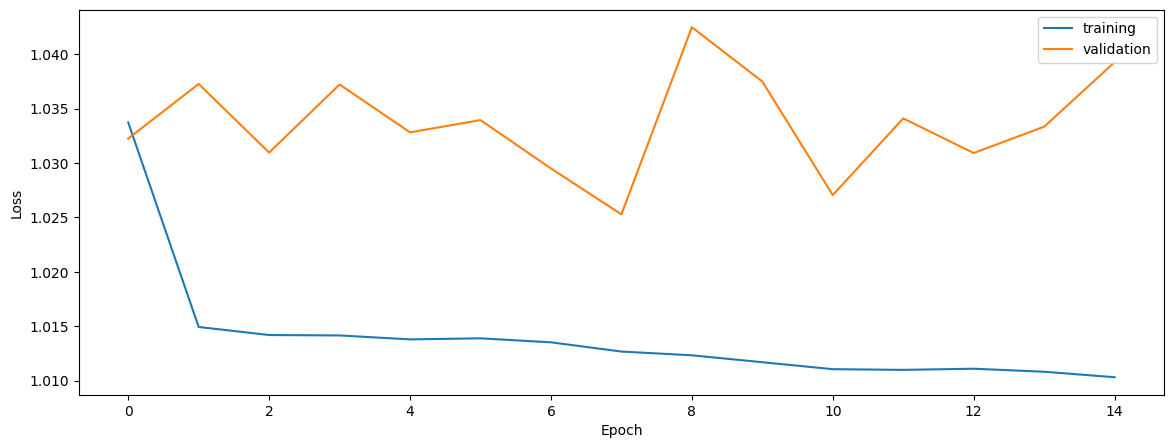

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.48485148802455064


0.4722045743329098


0.5089662753649741


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.5992297145595484


0.6053328370456218


0.6513240127771862


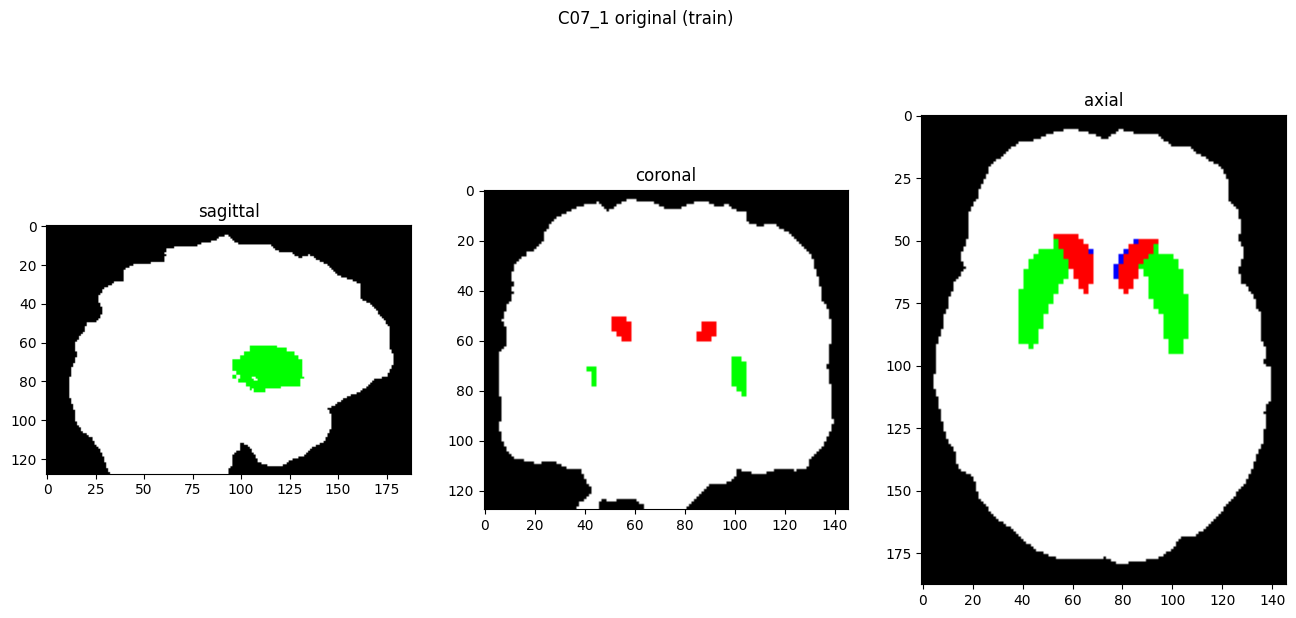

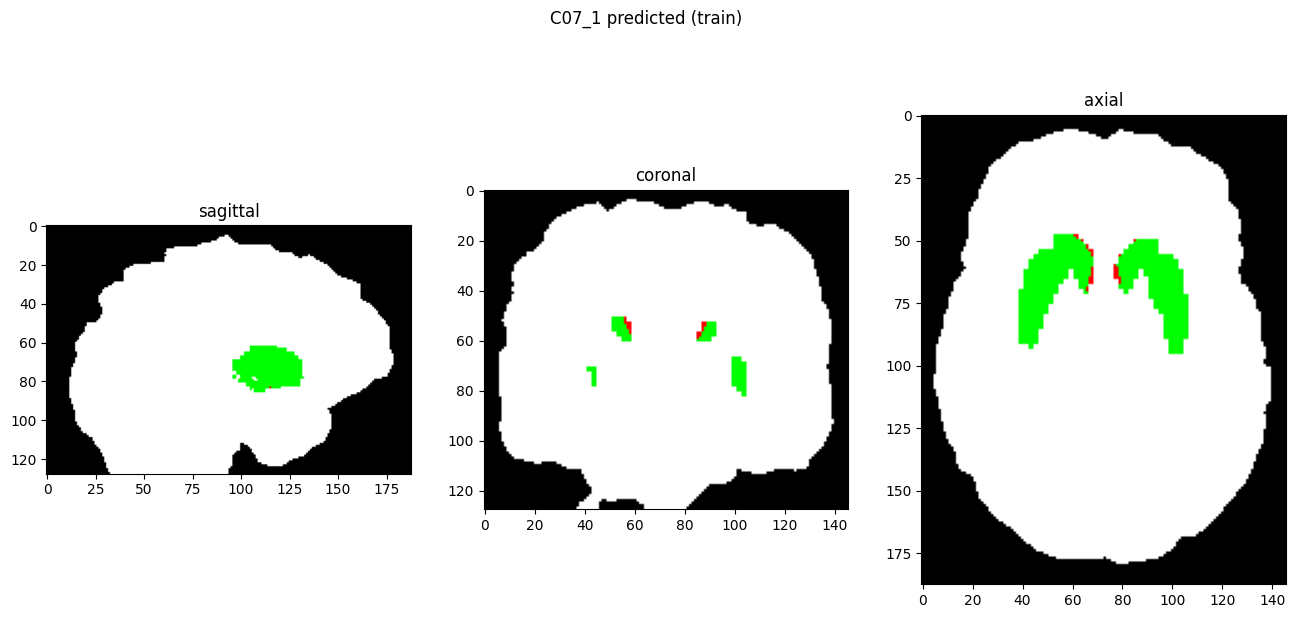

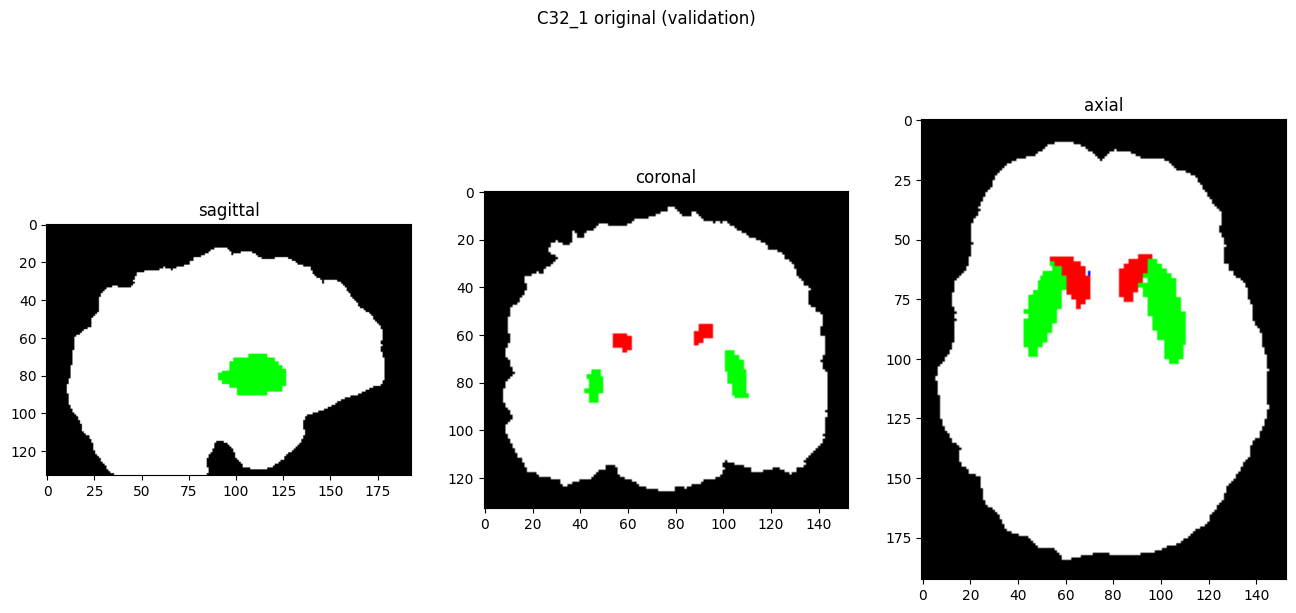

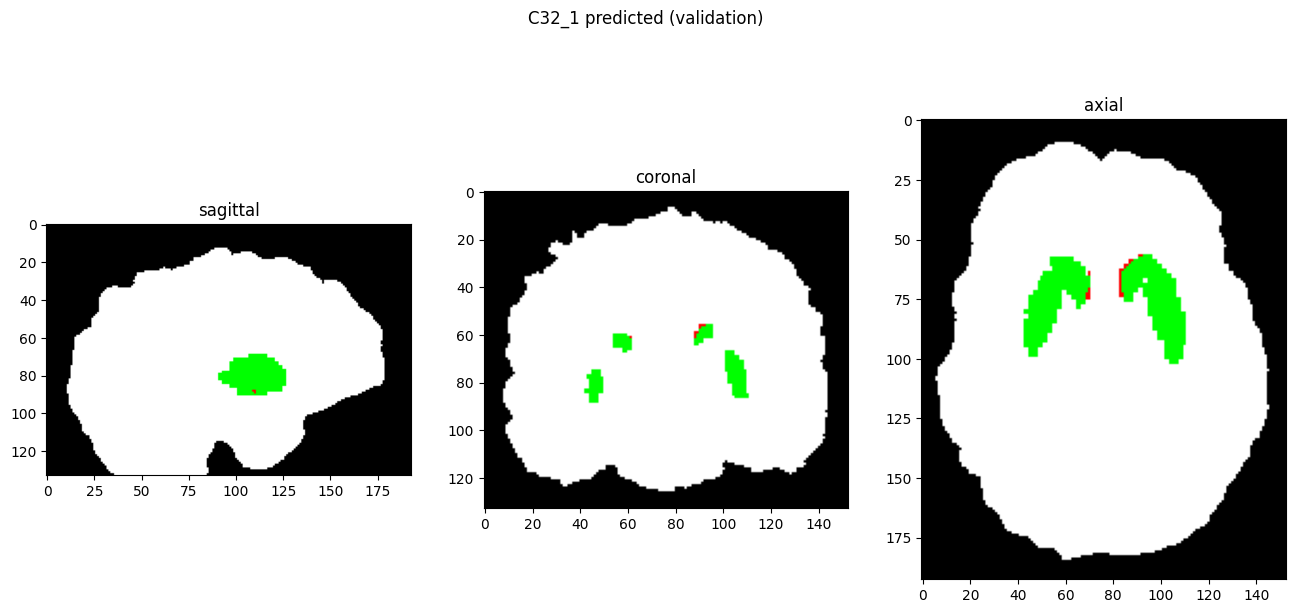

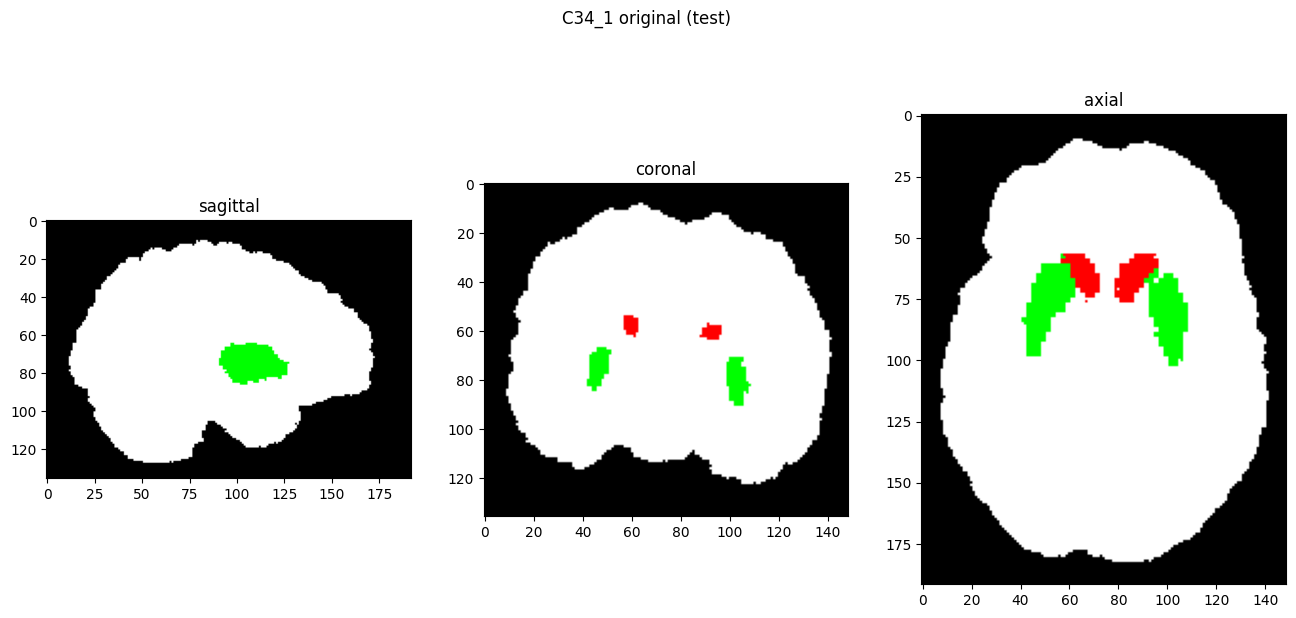

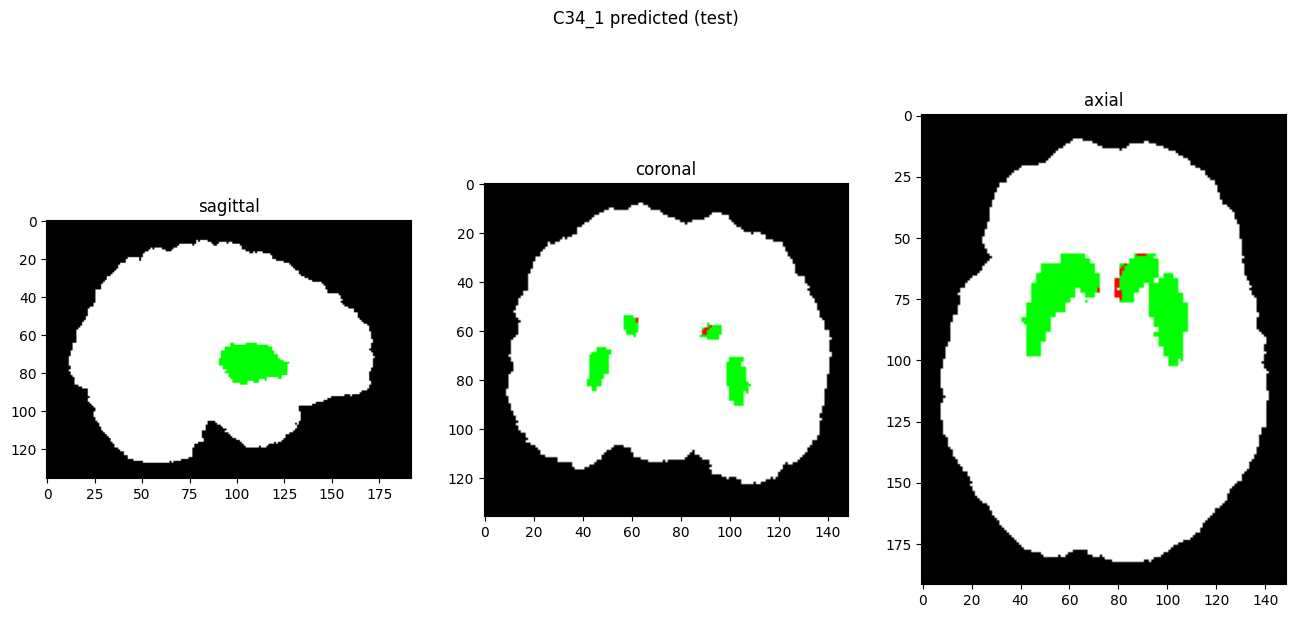

In [9]:
showResults(model, gen, threshold=0)